# Greedy Gradient Based Sample Selection (GSSGreedy)

We implement the greedy gradient based sample selection (GSSGreedy) method *[1]* for online continual learning.

Our implementation is based on [mammoth's `GSS`](https://github.com/aimagelab/mammoth/blob/master/utils/gss_buffer.py).



> "The problem of reservoir sampling is that the minor modes in the distribution
> with small probability mass may fail to be represented in the replay buffer.
> As a remedy to this problem, coverage maximization is also proposed in [8]. It
> intends to keep diverse samples in the replay buffer using Euclidean distance
> as a difference measure.While the Euclidean distance may be enough for low
> dimensional data, it could be uninformative when the data lies in a structured
> manifold embedded in a high dimensional space."
>
> Direct quote from *[1]*

---

1. Aljundi, R., Lin, M., Goujaud, B., & Bengio, Y. (2019). **Gradient based sample
   selection for online continual learning.** In H. M. Wallach, H. Larochelle, A.
   Beygelzimer, F. d’Alché-Buc, E. B. Fox, & R. Garnett (Eds.), Advances in
   neural information processing systems 32: Annual conference on neural
   information processing systems 2019, NeurIPS 2019, december 8-14, 2019,
   vancouver, BC, canada (pp. 11816–11825).
   https://proceedings.neurips.cc/paper/2019/hash/e562cd9c0768d5464b64cf61da7fc6bb-Abstract.html

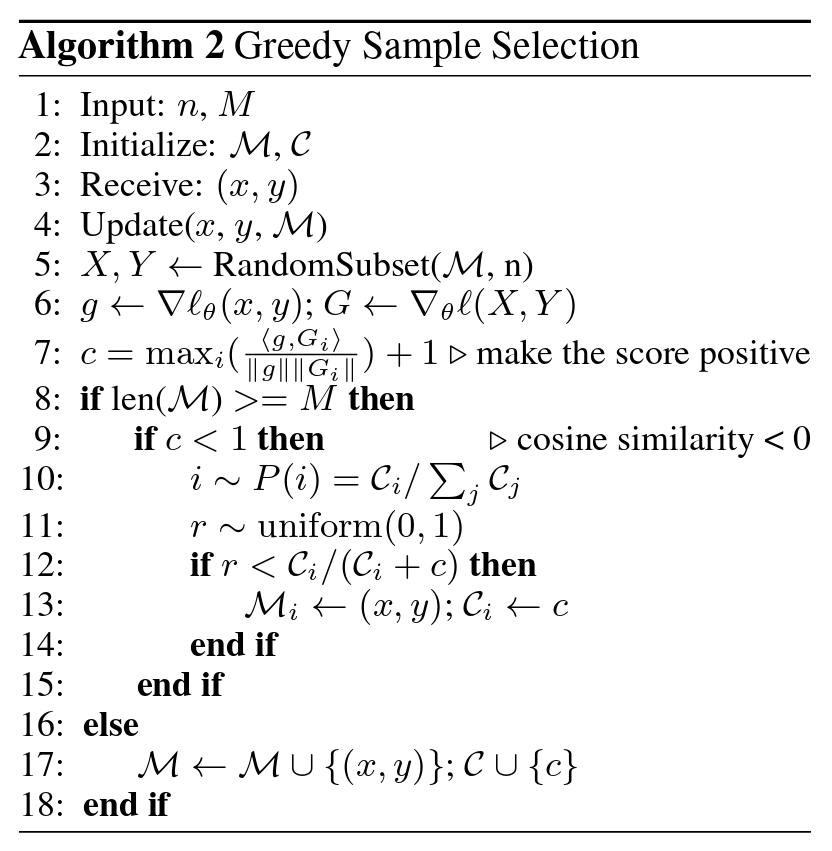

In [ ]:
from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor, nn


def grad_vector(model: nn.Module, x: Tensor, y: Tensor) -> Tensor:
    # Implements line 6 of Algorithm 2
    model.zero_grad()
    F.cross_entropy(model(x), y).backward()
    return torch.cat(
        [param.grad.view(-1) for param in model.parameters() if param.grad is not None]
    )


def batch_grad_vector(model: nn.Module, x: Tensor, y: Tensor) -> Tensor:
    return torch.stack(
        [
            grad_vector(model, x[i].unsqueeze(0), y[i].unsqueeze(0))
            for i in range(x.size(0))
        ]
    )


# def gss_score_fn(model: nn.Module, x: Tensor, y: Tensor, x_big: Tensor, y_big: Tensor) -> float:
#     if x_big.size(0) == 0:
#         return 0.1

#     # Line 7 of Algorithm 2
#     c_scores = torch.zeros(x_big.size(0), device=x.device)
#     g_grad = grad_vector(model, x, y)

#     for i in range(x_big.size(0)):
#         big_g = grad_vector(model, x_big[i].unsqueeze(0), y_big[i].unsqueeze(0))
#         c_scores[i] = F.cosine_similarity(g_grad, big_g, dim=0)

#     return c_scores.max().item() + 1


def gss_score_fn(single_g: Tensor, big_gs: Tensor) -> float:
    c_scores = torch.zeros(big_gs.size(0), device=single_g.device)

    for i in range(big_gs.size(0)):
        c_scores[i] = F.cosine_similarity(single_g, big_gs[i], dim=0)

    return c_scores.max().item()


def gss_reservoir_index(
    c: float,
    big_C: Tensor,
) -> Optional[int]:
    # Line 10->15 of Algorithm 2
    if c >= 1.0:
        return None
    p = (big_C / big_C.sum()).cpu().numpy()
    i = np.random.choice(np.arange(0, len(big_C)), size=1, p=p)[0]
    rand = np.random.rand(1)[0]
    if rand < big_C[i] / (big_C[i] + c):
        return i
    return None

In [ ]:
# class GSSGreedyBuffer:
#     def __init__(
#         self,
#         model: nn.Module,
#         item_count: int,
#         feature_count: int,
#         device: torch.device | str = torch.device("cpu"),
#     ):
#         self.device = torch.device(device)
#         self.model = model.to(device)
#         self.item_count = item_count
#         self.feature_count = feature_count
#         self.reservoir_x = torch.zeros((item_count, feature_count))
#         self.reservoir_y = torch.zeros((item_count,), dtype=torch.long)
#         self.reservoir_c = torch.zeros((item_count,))

#         self.reservoir_x = self.reservoir_x.to(device)
#         self.reservoir_y = self.reservoir_y.to(device)
#         self.reservoir_c = self.reservoir_c.to(device)
#         self.count = 0

#     def update(self, x: Tensor, y: Tensor) -> None:
#         batch_size = x.shape[0]
#         assert x.shape == (
#             batch_size,
#             self.feature_count,
#         )
#         assert y.shape == (batch_size,)

#         if self.count > 0:
#             big_Gs = batch_grad_vector(self.model, self.reservoir_x[:self.count], self.reservoir_y[:self.count])
#             gs = batch_grad_vector(self.model, x, y)
#             cs = torch.tensor([gss_score_fn(single_g=gs[i], big_gs=big_Gs) for i in range(batch_size)], device=self.device)
#         else:
#             cs = torch.zeros(batch_size, device=self.device)

#         print(f"cs.max(): {cs.max().item()} cs.min(): {cs.min().item()} cs.mean(): {cs.mean().item()}")

#         for i in range(batch_size):

#             if self.count < self.item_count:
#                 # Fill the reservoir
#                 self.reservoir_x[self.count] = x[i]
#                 self.reservoir_y[self.count] = y[i]
#                 self.reservoir_c[self.count] = cs[i]
#             elif (index := gss_reservoir_index(cs[i].item(), self.reservoir_c[:self.count])) is not None:
#                 print(f"Replacing {index}")
#                 self.reservoir_x[index] = x[i]
#                 self.reservoir_y[index] = y[i]
#                 self.reservoir_c[index] = cs[i]
#             self.count += 1

#     def sample_n(self, n: int) -> Tuple[Tensor, Tensor]:
#         indices = torch.randint(0, min(self.count, self.item_count), (n,))
#         return self.reservoir_x[indices], self.reservoir_y[indices]

In [ ]:
"""
This module contains a version of the reservoir buffer that is specifically designed for the GSS model.
"""

# Copyright 2020-present, Pietro Buzzega, Matteo Boschini, Angelo Porrello, Davide Abati, Simone Calderara.
# All rights reserved.
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.


class RefGSSBuffer:
    """
    Memory buffer for the GSS model.
    The buffer supports only `examples` and `labels` tensors.
    """

    def __init__(
        self,
        buffer_size,
        device,
        model,
        in_features: int,
        rng: torch.Generator = torch.default_generator,
    ):
        self.buffer_size = buffer_size
        self.device = device
        self.num_seen_examples = 0
        self.model = model
        self.cache = {}
        self.rng = rng

        self.examples = torch.zeros(
            size=(self.buffer_size, in_features),
            dtype=torch.float32,
            device=self.device,
        )
        self.labels = torch.zeros(
            size=(self.buffer_size,), dtype=torch.long, device=self.device
        )
        self.scores = torch.zeros(
            size=(self.buffer_size,), dtype=torch.float32, device=self.device
        )

    def get_grad_score(self, batch_x, batch_y, X, Y, indices):
        g = grad_vector(self.model, batch_x, batch_y)
        G = []
        for x, y, idx in zip(X, Y, indices):
            if idx in self.cache:
                grd = self.cache[idx]
            else:
                # grd = self.model.get_grads(x.unsqueeze(0), y.unsqueeze(0))
                grd = grad_vector(self.model, x.unsqueeze(0), y.unsqueeze(0))
                self.cache[idx] = grd
            G.append(grd)
        G = torch.stack(G).to(g.device)
        c_score = 0
        grads_at_a_time = 5
        # let's split this so your gpu does not melt. You're welcome.
        for it in range(int(np.ceil(G.shape[0] / grads_at_a_time))):
            tmp = (
                F.cosine_similarity(
                    g, G[it * grads_at_a_time : (it + 1) * grads_at_a_time], dim=1
                )
                .max()
                .item()
                + 1
            )
            c_score = max(c_score, tmp)
        return c_score

    def functional_reservoir(self, x, y, batch_c, bigX=None, bigY=None, indices=None):
        if self.num_seen_examples < self.buffer_size:
            return self.num_seen_examples, batch_c
        elif batch_c < 1:
            print("Updating ", batch_c)
            single_c = self.get_grad_score(
                x.unsqueeze(0), y.unsqueeze(0), bigX, bigY, indices
            )
            s = self.scores
            p = s / s.sum()
            i = torch.multinomial(p.cpu(), num_samples=1, generator=self.rng).item()
            rand = torch.rand(1).item()
            if rand < s[i].item() / (s[i].item() + single_c):
                return i, single_c

        return -1, 0

    def update(self, x: Tensor, y: Tensor) -> None:
        self.drop_cache()

        # compute buffer score
        if self.num_seen_examples > 0:
            bigX, bigY, indices = self.sample_n(
                min(len(x), self.num_seen_examples),
                give_index=True,
            )
            c = self.get_grad_score(x, y, bigX, bigY, indices)
            # print(f"{self.num_seen_examples:02d}:{c:0.3f}")
        else:
            bigX, bigY, indices = None, None, None
            c = 0.1

        for i in range(x.shape[0]):
            index, score = self.functional_reservoir(x[i], y[i], c, bigX, bigY, indices)
            self.num_seen_examples += 1
            if index >= 0:
                idx = int(index)
                self.examples[idx] = x[i].to(self.device)
                if y is not None:
                    self.labels[idx] = y[i].to(self.device)
                self.scores[idx] = score
                if idx in self.cache:
                    del self.cache[idx]

    def drop_cache(self):
        self.cache = {}

    def sample_n(self, size: int, give_index=False, device=None) -> Tuple:
        if size > self.examples.shape[0]:
            size = self.examples.shape[0]

        choice = np.random.choice(
            min(self.num_seen_examples, self.examples.shape[0]),
            size=min(size, self.num_seen_examples),
            replace=False,
        )

        if give_index:
            return (self.examples[choice], self.labels[choice], choice)
        else:
            return (self.examples[choice], self.labels[choice])

In [ ]:
# import torch
# import torch.nn.functional as F

# # from utils.buffer.buffer_utils import get_grad_vector, cosine_similarity


# def maybe_cuda(what, use_cuda=True, **kw):
#     """
#     Moves `what` to CUDA and returns it, if `use_cuda` and it's available.
#         Args:
#             what (object): any object to move to eventually gpu
#             use_cuda (bool): if we want to use gpu or cpu.
#         Returns
#             object: the same object but eventually moved to gpu.
#     """

#     if use_cuda is not False and torch.cuda.is_available():
#         what = what.cuda()
#     return what


# def get_grad_vector(pp, grad_dims):
#     """
#     gather the gradients in one vector
#     """
#     grads = maybe_cuda(torch.Tensor(sum(grad_dims)))
#     grads.fill_(0.0)
#     cnt = 0
#     for param in pp():
#         if param.grad is not None:
#             beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
#             en = sum(grad_dims[: cnt + 1])
#             grads[beg:en].copy_(param.grad.data.view(-1))
#         cnt += 1
#     return grads


# def cosine_similarity(x1, x2=None, eps=1e-8):
#     x2 = x1 if x2 is None else x2
#     w1 = x1.norm(p=2, dim=1, keepdim=True)
#     w2 = w1 if x2 is x1 else x2.norm(p=2, dim=1, keepdim=True)
#     sim = torch.mm(x1, x2.t()) / (w1 * w2.t()).clamp(min=eps)
#     return sim


# class GSSGreedyUpdate:
#     def __init__(
#         self,
#         model: nn.Module,
#         size: int,
#         in_features: int,
#         gss_batch_size: int = 10,
#         mem_strength: int = 10,
#         device: torch.device | str = torch.device("cpu"),
#     ):
#         super().__init__()
#         # the number of gradient vectors to estimate new samples similarity, line 5 in alg.2
#         self.mem_strength = mem_strength
#         self.gss_batch_size = gss_batch_size
#         self.device = device
#         self.model = model.to(device)
#         self.buffer_i = 0
#         self.buffer_size = size
#         self.buffer_score = torch.zeros(size, dtype=torch.float32, device=device)
#         self.buffer_img = torch.zeros(
#             (size, in_features), dtype=torch.float32, device=device
#         )
#         self.buffer_label = torch.zeros((size,), dtype=torch.long, device=device)

#     def update(self, x, y, **kwargs):
#         self.model.eval()

#         grad_dims = []
#         for param in self.model.parameters():
#             grad_dims.append(param.data.numel())

#         place_left = self.buffer_img.size(0) - self.buffer_i
#         if place_left <= 0:  # buffer is full
#             batch_sim, mem_grads = self.get_batch_sim(grad_dims, x, y)
#             if batch_sim < 0:
#                 buffer_score = self.buffer_score[: self.buffer_i].cpu()
#                 buffer_sim = (buffer_score - torch.min(buffer_score)) / (
#                     (torch.max(buffer_score) - torch.min(buffer_score)) + 0.01
#                 )
#                 # draw candidates for replacement from the buffer
#                 index = torch.multinomial(buffer_sim, x.size(0), replacement=False)
#                 # estimate the similarity of each sample in the recieved batch
#                 # to the randomly drawn samples from the buffer.
#                 batch_item_sim = self.get_each_batch_sample_sim(
#                     self.model, grad_dims, mem_grads, x, y
#                 )
#                 # normalize to [0,1]
#                 scaled_batch_item_sim = ((batch_item_sim + 1) / 2).unsqueeze(1)
#                 buffer_repl_batch_sim = ((self.buffer_score[index] + 1) / 2).unsqueeze(
#                     1
#                 )
#                 # draw an event to decide on replacement decision
#                 outcome = torch.multinomial(
#                     torch.cat((scaled_batch_item_sim, buffer_repl_batch_sim), dim=1),
#                     1,
#                     replacement=False,
#                 ).cpu()
#                 # replace samples with outcome =1
#                 added_indx = torch.arange(end=batch_item_sim.size(0))
#                 sub_index = outcome.squeeze(1).bool()
#                 self.buffer_img[index[sub_index]] = (
#                     x[added_indx[sub_index]].clone().to(self.device)
#                 )
#                 self.buffer_label[index[sub_index]] = (
#                     y[added_indx[sub_index]].clone().to(self.device)
#                 )
#                 self.buffer_score[index[sub_index]] = (
#                     batch_item_sim[added_indx[sub_index]].clone().to(self.device)
#                 )
#         else:
#             offset = min(place_left, x.size(0))
#             x = x[:offset]
#             y = y[:offset]
#             # first buffer insertion
#             if self.buffer_i == 0:
#                 batch_sample_memory_cos = torch.zeros(x.size(0)) + 0.1
#             else:
#                 # draw random samples from buffer
#                 mem_grads = self.get_rand_mem_grads(grad_dims)
#                 # estimate a score for each added sample
#                 batch_sample_memory_cos = self.get_each_batch_sample_sim(
#                     self.model, grad_dims, mem_grads, x, y
#                 )
#             self.buffer_img[self.buffer_i : self.buffer_i + offset].data.copy_(x)
#             self.buffer_label[self.buffer_i : self.buffer_i + offset].data.copy_(y)
#             self.buffer_score[self.buffer_i : self.buffer_i + offset].data.copy_(
#                 batch_sample_memory_cos
#             )
#             self.buffer_i += offset

#     def get_batch_sim(self, grad_dims, batch_x, batch_y):
#         """
#         Args:
#             buffer: memory buffer
#             grad_dims: gradient dimensions
#             batch_x: batch images
#             batch_y: batch labels
#         Returns: score of current batch, gradient from memory subsets
#         """
#         mem_grads = self.get_rand_mem_grads(grad_dims)
#         self.model.zero_grad()
#         loss = F.cross_entropy(self.model.forward(batch_x), batch_y)
#         loss.backward()
#         batch_grad = get_grad_vector(self.model.parameters, grad_dims).unsqueeze(0)
#         batch_sim = max(cosine_similarity(mem_grads, batch_grad))
#         return batch_sim, mem_grads

#     def get_rand_mem_grads(self, grad_dims):
#         """
#         Args:
#             buffer: memory buffer
#             grad_dims: gradient dimensions
#         Returns: gradient from memory subsets
#         """
#         gss_batch_size = min(self.gss_batch_size, self.buffer_i)
#         num_mem_subs = min(self.mem_strength, self.buffer_i // gss_batch_size)
#         mem_grads = maybe_cuda(
#             torch.zeros((num_mem_subs, sum(grad_dims)), dtype=torch.float32)
#         )
#         shuffeled_inds = torch.randperm(self.buffer_i)
#         for i in range(num_mem_subs):
#             random_batch_inds = shuffeled_inds[
#                 i * gss_batch_size : i * gss_batch_size + gss_batch_size
#             ]
#             batch_x = self.buffer_img[random_batch_inds]
#             batch_y = self.buffer_label[random_batch_inds]
#             self.model.zero_grad()
#             loss = F.cross_entropy(self.model.forward(batch_x), batch_y)
#             loss.backward()
#             mem_grads[i].data.copy_(get_grad_vector(self.model.parameters, grad_dims))
#         return mem_grads

#     def get_each_batch_sample_sim(
#         self, model: nn.Module, grad_dims, mem_grads, batch_x, batch_y
#     ):
#         """
#         Args:
#             buffer: memory buffer
#             grad_dims: gradient dimensions
#             mem_grads: gradient from memory subsets
#             batch_x: batch images
#             batch_y: batch labels
#         Returns: score of each sample from current batch
#         """
#         cosine_sim = maybe_cuda(torch.zeros(batch_x.size(0)))
#         for i, (x, y) in enumerate(zip(batch_x, batch_y)):
#             model.zero_grad()
#             ptloss = F.cross_entropy(model.forward(x.unsqueeze(0)), y.unsqueeze(0))
#             ptloss.backward()
#             # add the new grad to the memory grads and add it is cosine similarity
#             this_grad = get_grad_vector(model.parameters, grad_dims).unsqueeze(0)
#             cosine_sim[i] = max(cosine_similarity(mem_grads, this_grad))
#         return cosine_sim

#     def sample_n(self, n: int) -> Tuple[Tensor, Tensor]:
#         indices = torch.randint(0, min(self.buffer_i, self.buffer_size), (n,))
#         return self.buffer_img[indices], self.buffer_label[indices]

In [ ]:
from capymoa.base import BatchClassifier
from capymoa.stream import Schema
from torch import nn
from torch.nn.functional import cross_entropy


class GSSGreedy(BatchClassifier):
    def __init__(
        self,
        schema: Schema,
        model: nn.Module,
        reservoir_size: int,
        learning_rate: float,
        repeat_replay: int = 1,
        device: str = "cpu",
        seed: int = 0,
    ):
        super().__init__(schema=schema)
        self.reservoir = RefGSSBuffer(
            buffer_size=reservoir_size,
            device=device,
            model=model,
            in_features=schema.get_num_attributes(),
            rng=torch.Generator().manual_seed(seed),
        )
        self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.model = model.to(device)
        self.device = torch.device(device)
        self.repeat_replay = repeat_replay

    def batch_train(self, x: Tensor, y: Tensor):
        self.reservoir.update(x, y)
        # print(self.reservoir.labels.unique(return_counts=True))

        for _ in range(self.repeat_replay):
            replay_x, replay_y = self.reservoir.sample_n(x.shape[0])
            train_x = torch.cat((x, replay_x), dim=0).to(self.device)
            train_y = torch.cat((y, replay_y), dim=0).to(self.device)

            self.optimizer.zero_grad()
            y_hat = self.model(train_x)
            loss = cross_entropy(y_hat, train_y)
            loss.backward()
            self.optimizer.step()

    @torch.no_grad()
    def batch_predict_proba(self, x: Tensor) -> Tensor:
        self.model.eval()
        return self.model(x).softmax(dim=1)

    def __str__(self) -> str:
        return "ExperienceReplay"

In [ ]:
from capymoa.ann import LeNet5
from capymoa.classifier import Finetune
from capymoa.ocl.datasets import SplitFashionMNIST
from capymoa.ocl.evaluation import ocl_train_eval_loop
from capymoa.ocl.strategy import ExperienceReplay
from torch.utils.data import random_split

In [ ]:
scenario = SplitFashionMNIST(shuffle_tasks=False)


def decimate(dataset):
    return random_split(dataset, [0.2, 0.8], torch.Generator().manual_seed(0))[0]


scenario.train_tasks = [
    decimate(scenario.train_tasks[0]),
    scenario.train_tasks[1],
    decimate(scenario.train_tasks[2]),
    scenario.train_tasks[3],
    decimate(scenario.train_tasks[4]),
]

In [ ]:
gss = GSSGreedy(scenario.schema, LeNet5(10), 200, 0.001, device="cuda", repeat_replay=5)

results = {}
results["gss"] = ocl_train_eval_loop(
    gss,
    scenario.train_loaders(16),
    scenario.test_loaders(128),
    progress_bar=True,
    eval_window_size=100,
)

In [ ]:
gss.reservoir.labels.unique(return_counts=True)

In [ ]:
er = ExperienceReplay(Finetune(scenario.schema, LeNet5(10)), 200, repeat_replay=5)

results["er"] = ocl_train_eval_loop(
    er,
    scenario.train_loaders(64),
    scenario.test_loaders(128),
    progress_bar=True,
    eval_window_size=100,
)

In [ ]:
er._buffer.reservoir_y.unique(return_counts=True)

In [ ]:
from plot import plot_multiple

plot_multiple(results, acc_seen=True)

In [ ]:
# https://github.com/RaptorMai/online-continual-learning/blob/6175ca034e56435acd82b8f17ff59f920f0bc45e/utils/buffer/gss_greedy_update.py#L7